### 2018/2019 - Task List 4

[Book](https://raw.githubusercontent.com/jonesgithub/book-1/master/ML%20Machine%20Learning-A%20Probabilistic%20Perspective.pdf)

[A priori](https://en.wikipedia.org/wiki/A_priori_probability)

[Likelihood](https://en.wikipedia.org/wiki/Likelihood_function)

[Posteriori](https://en.wikipedia.org/wiki/Posterior_distribution)

[Conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior)

Pyro
[Conditioning](http://pyro.ai/examples/intro_part_ii.html#Conditioning)

Pyro [SVI](http://pyro.ai/examples/svi_part_i.html#Setup)

1.  Select one attriubte from one of the datasets (Task List 3), that has distribution similar to Normal (or any known to you distribution)
2.  Asume that you have some prior knowledge about parameters of that distribution
3.  Create model, and apropriate guid function
4. Learn parameter of your distribution, assume that you know STD or mean

## Required imports

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from pyro.optim import Adam
from torch.distributions import constraints
from tqdm import tqdm
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
pyro.set_rng_seed(1)
#force pyro to validate
pyro.enable_validation(True)

#  Example of SVI

Generate some sample data of weight measurments

In [3]:
mean, std = 100, 10
with pyro.plate("generator", 1000) as _:
    data = pyro.sample('data', pyro.distributions.Normal(mean, std))
    
prior_mean=80


In [4]:
data

tensor([ 84.7440,  92.4977,  93.4602,  83.9052,  98.9983,  93.9081,  90.2023,
         83.9090,  92.8786, 103.0372,  92.2269,  97.4855,  97.7773, 116.8711,
        102.2842, 104.6764,  93.0303,  88.3924, 106.9954, 101.9908, 108.6569,
        102.4440,  93.3709, 108.0731, 111.0168,  98.2406,  77.5444,  85.5354,
        100.6115,  93.8226,  92.0193,  98.6838, 118.7935,  99.2787, 101.5777,
         92.2654, 101.9906, 100.4570, 101.5296,  95.2432,  98.8898, 102.9274,
         98.4215,  99.7121, 123.5711,  89.6266, 115.7480,  93.7015,  90.7261,
        105.4514, 100.6628,  95.6296, 107.6260, 104.4151, 111.6514, 120.1539,
        101.3741, 109.3864,  98.1400,  93.5536, 115.3925,  91.3041,  66.6885,
         92.5213,  99.7450,  89.7667,  94.0381,  89.9447,  97.8939,  99.9245,
        116.7343, 100.1034,  92.9604,  98.1473,  90.0377,  91.6874,  95.3898,
         94.3992, 103.9558,  90.1772,  94.9351, 100.9978,  93.4603, 107.3169,
         85.6561,  94.9919, 101.7163,  98.4001, 102.5463,  94.98

In [5]:
data.mean()

tensor(100.0873)

In [6]:
data.std()

tensor(10.2937)

Create model. We use prior belief about input values, and condition on data

In [7]:
noise_std=0.5
def model(data):  # equivalent to conditioned_scale above
    prior=pyro.distributions.Normal(prior_mean, 1.)
    weight = pyro.sample("weight", prior)
    with pyro.plate("map", len(data)):
        pyro.sample("measurement", pyro.distributions.Normal(weight, noise_std), obs=data)

Create guid function that has corresponging weight laten variable. We use one parameter mean with starting value 150, assuming std to be 10

In [8]:
def guide(data):
    mean = pyro.param("mean", torch.tensor(150.), constraint=constraints.positive)
    return pyro.sample("weight", pyro.distributions.Normal(mean, 10))


Create SVI with Adam optimizer, ELBO loss, our guide and model

In [9]:
optim = Adam({"lr": 0.0003})
svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=optim,
                     loss=pyro.infer.Trace_ELBO(), num_samples=len(data))

Train the model

In [10]:
pyro.clear_param_store()
losses, mean  = [], []
num_steps = 6000
for t in tqdm(range(num_steps)):
    losses.append(svi.step(data))
    mean.append(pyro.param("mean"))


100%|██████████| 6000/6000 [00:26<00:00, 224.65it/s]


Plot loss

learned mean =  tensor(99.6269, grad_fn=<AddBackward0>)


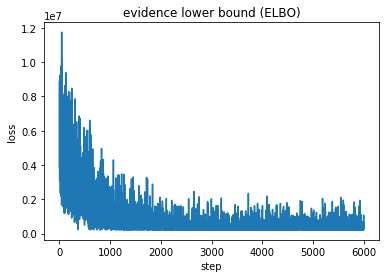

In [11]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");
print('learned mean = ',pyro.param("mean"))

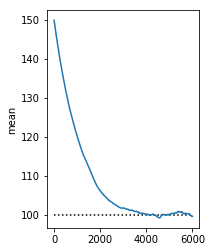

In [12]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[data.mean(),data.mean()], 'k:')
plt.plot(mean)
plt.ylabel('mean');

In [13]:
mean[-1]

tensor(99.6269, grad_fn=<AddBackward0>)

## Task

In [14]:
## Insert solution here